# 导入所需包

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import gc
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold,KFold
import numpy as np
import random

In [2]:
np.random.seed(0)
random.seed(0)

# 读取数据

由于数据或按季或按月分别存储在不同的文件中，按照个人习惯，笔者会将其归并并且，再对常用指标项进行统计。

## 标签

In [3]:
y_Q3 = pd.read_csv('./raw/y_Q3_3.csv')
y_Q4 = pd.read_csv('./raw/y_Q4_3.csv')

In [4]:
y_Q3['Q'] = 3
y_Q4['Q'] = 4
y = pd.concat([y_Q3,y_Q4],axis=0,ignore_index=True)

In [5]:
y.head(5)

,cust_no,label,Q
0,0xb2d640a6,0,3
1,0xb2d4dd44,-1,3
2,0xb2d69fef,1,3
3,0xb2d42c89,0,3
4,0xb2d90b58,-1,3


In [6]:
y.Q.value_counts()

4    76170
3    69126
Name: Q, dtype: int64

In [7]:
len(y)

145296

In [8]:
y.label.value_counts(normalize=True)

 1    0.638820
 0    0.208106
-1    0.153074
Name: label, dtype: float64

In [9]:
y_Q3.label.value_counts(normalize=True)

 1    0.628157
 0    0.217718
-1    0.154124
Name: label, dtype: float64

In [10]:
y_Q4.label.value_counts(normalize=True)

 1    0.648497
 0    0.199383
-1    0.152120
Name: label, dtype: float64

    有对应用户的第3季度和第4季度两个季度标签数据。
    第3季度有69126个样本，第4季度有7610个样本。总计14.5w样本。
    label为1代表行内资产相对上个季度上升，label为0代表相对上个季度行内资产稳定，label为-1代表下降。
    第4季度和第3季度相比，资产上升的用户比例增多，稳定和下降的用户减少。

## 待预测的样本id

In [11]:
cust_avli_Q3 = pd.read_csv('./raw/cust_avli_Q3.csv')
cust_avli_Q4 = pd.read_csv('./raw/cust_avli_Q4.csv')
cust_avli_Q1 = pd.read_csv('./raw/cust_avli_Q1.csv')

In [12]:
cust_avli_Q3['Q'] = 3
cust_avli_Q4['Q'] = 4
cust_avli_Q1['Q'] = 1

In [13]:
print(cust_avli_Q3.shape)
print(cust_avli_Q4.shape)
print(cust_avli_Q1.shape)

(69126, 2)
(76170, 2)
(76722, 2)


In [14]:
cust_avli = pd.concat([cust_avli_Q3,cust_avli_Q4,cust_avli_Q1],axis=0,ignore_index=True)

In [15]:
cust_avli.Q.value_counts(normalize=True)

1    0.345567
4    0.343080
3    0.311353
Name: Q, dtype: float64

    1季度为需要模型预测的季度，同时作为模型效果的线上评分集。
    从数据量上来看1季度和4季度的数据量接近，3季度和4季度数量有所差别。

In [16]:
print(cust_avli[cust_avli.Q == 3].cust_no.nunique())
print(cust_avli.cust_no[cust_avli.Q == 3][cust_avli.cust_no[cust_avli.Q == 3].isin(cust_avli.cust_no[cust_avli.Q == 4])].nunique())

69126
62397


In [17]:
print(cust_avli[cust_avli.Q == 4].cust_no.nunique())
print(cust_avli.cust_no[cust_avli.Q == 4][cust_avli.cust_no[cust_avli.Q == 4].isin(cust_avli.cust_no[cust_avli.Q == 1])].nunique())

76170
69441


In [18]:
62397/69126

0.9026560194427568

In [19]:
69441/76170

0.9116581331232769

    我们并不知道主办方提取数据的具体逻辑。但是可以客观的看一下3个季度用户的重合情况。
    发现3季度流入4季度的用户占3月份90%，4季度流入1季度的91%左右。数据情况稳定。

对于4季度的用户而言，可以按照上个季度该用户的标签是什么来进行分类，分别为1,0,-1,无。

In [20]:
y

,cust_no,label,Q
0,0xb2d640a6,0,3
1,0xb2d4dd44,-1,3
2,0xb2d69fef,1,3
3,0xb2d42c89,0,3
4,0xb2d90b58,-1,3
...,...,...,...
145291,0xb2d174f1,1,4
145292,0x3b9af14f,0,4
145293,0xb2d1bb5d,0,4
145294,0xb2d9ed26,1,4


In [21]:
y_ = y.copy()
y_.columns = ['cust_no','last_label','Q']
y_.Q = y_.Q.map({3:4,4:1,1:2})
y_ = y.merge(y_,on=['cust_no','Q'],how='left')

In [22]:
cross_df = pd.crosstab(y_.last_label[y_.Q==4].fillna('NA'),y_[y_.Q==4].label, dropna=False)

In [23]:
cross_df

label,-1,0,1
last_label,,,
-1.0,2862,885,1514
0.0,2179,5145,6967
1.0,3126,7636,32083
NA,3420,1521,8832


In [24]:
(cross_df.T/cross_df.sum(axis=1)).T

label,-1,0,1
last_label,,,
-1.0,0.544003,0.168219,0.287778
0.0,0.152474,0.360017,0.487510
1.0,0.072961,0.178224,0.748815
NA,0.248312,0.110433,0.641255


    由上表可见，
    本季度的标签会与上个季度的标签趋向于表现一致。
    所以将上个季度的用户表现作为特征输入应该会比较不错。

## cust_info

In [25]:
cust_info_Q3 = pd.read_csv('./raw/cust_info_q3.csv')
cust_info_Q4 = pd.read_csv('./raw/cust_info_q4.csv')
cust_info_Q1 = pd.read_csv('./raw/cust_info_q1.csv')

In [26]:
print(cust_info_Q3.shape)
print(cust_info_Q4.shape)
print(cust_info_Q1.shape)

(493441, 21)
(543823, 21)
(659624, 21)


In [27]:
cust_info_Q3['Q'] = 3
cust_info_Q4['Q'] = 4
cust_info_Q1['Q'] = 1
cust_info = pd.concat([cust_info_Q3,cust_info_Q4,cust_info_Q1],axis=0,ignore_index=True)

In [28]:
cust_info.Q.value_counts()

1    659624
4    543823
3    493441
Name: Q, dtype: int64

In [29]:
cust_info.head()

,cust_no,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,I12,I13,I14,I15,I16,I17,I18,I19,I20,Q
0,0x3b9b38ae,女性,26,普通客户,0.0,NaN,0,0,摩羯座,NaN,...,个人,NaN,NaN,0,0.0,0,0,0,0,3
1,0xb2d483a9,NaN,42,普通客户,0.0,NaN,0,0,天蝎座,NaN,...,个人,NaN,NaN,0,0.0,0,0,0,0,3
2,0xb2d5ee67,男性,45,普通客户,0.0,不便分类的其他从业人员,0,0,天秤座,NaN,...,个人,NaN,NaN,0,0.0,1,1,1,0,3
3,0xb2d7382b,男性,38,普通客户,0.0,商业工作人员,0,0,金牛座,NaN,...,个人,NaN,NaN,0,0.0,0,0,0,0,3
4,0xb2d75925,男性,32,普通客户,0.0,不便分类的其他从业人员,0,0,天蝎座,NaN,...,个人,未说明的婚姻状况,未知,0,0.0,0,0,0,0,3


In [30]:
del cust_info_Q1,cust_info_Q3,cust_info_Q4
gc.collect()

60

In [31]:
#这里对I3-客户等级。I16-VIP客户标志，季度差分，即将上一个季度和本季度的情况拼接起来作为新的特征

In [32]:
df1 = cust_info[['cust_no','I16','I3','Q']]
df2 = df1.copy()
df2.Q = df2.Q.map({1:2,3:4,4:1})
df1 = df1.merge(df2,on=['cust_no','Q'],how='left')

df1['I3_diff'] = df1.I3_y +'_'+ df1.I3_x
df1['I16_diff'] = df1.I16_y - df1.I16_x

df1 = df1[['cust_no','Q','I3_diff','I16_diff']]
cust_info = cust_info.merge(df1,on=['cust_no','Q'],how='left')

In [33]:
#对于离散的特征变量统一做LabelEncoder处理。

In [34]:
le = LabelEncoder()
cats_col = ['I1','I3','I4','I5','I8','I10','I12','I13','I14','I3_diff']
for col in cats_col:
    print(col)
    cust_info.loc[~cust_info[col].isna(),col] = le.fit_transform(cust_info.loc[~cust_info[col].isna(),col])
    cust_info[col] = cust_info[col].astype('float')

I1
I3
I4
I5
I8
I10
I12
I13
I14
I3_diff


In [35]:
cust_info = cust_avli.merge(cust_info,on=['cust_no','Q'],how='left')

In [36]:
cust_info.Q.value_counts()

1    76722
4    76170
3    69126
Name: Q, dtype: int64

## aum

In [37]:
#aum系列的数据是按月份给出的。在这里做了两件事
#使用X1-X8排除X7相加得到一个新值X9，X8为贷款相当于负向资产，其余加和作为正向资产。
#同时按照季度+用户作为样本主键，把每3个月的aum进行展平。
#3个月，每个月9个特征，展平得到27个特征，命名从X0到X26

In [38]:
aum_m7 = pd.read_csv('./raw/aum_m7.csv')
aum_m8 = pd.read_csv('./raw/aum_m8.csv')
aum_m9 = pd.read_csv('./raw/aum_m9.csv')
aum_m10 = pd.read_csv('./raw/aum_m10.csv')
aum_m11 = pd.read_csv('./raw/aum_m11.csv')
aum_m12 = pd.read_csv('./raw/aum_m12.csv')
aum_m1 = pd.read_csv('./raw/aum_m1.csv')
aum_m2 = pd.read_csv('./raw/aum_m2.csv')
aum_m3 = pd.read_csv('./raw/aum_m3.csv')

for aum in [aum_m7,aum_m8,aum_m9,aum_m10,aum_m11,aum_m12,aum_m1,aum_m2,aum_m3]:
    aum['X9'] = aum['X1']+aum['X2']+aum['X3']+aum['X4']+aum['X5']+aum['X6']+aum['X8']

cols = ['X' + str(i) for i in range(27)]

aum_m7 = aum_m7.set_index('cust_no')
aum_m8 = aum_m8.set_index('cust_no')
aum_m9 = aum_m9.set_index('cust_no')
aum_Q3 = pd.concat([aum_m7,aum_m8,aum_m9],axis=1)
aum_Q3.columns = cols

aum_m10 =aum_m10.set_index('cust_no')
aum_m11 =aum_m11.set_index('cust_no')
aum_m12 =aum_m12.set_index('cust_no')
aum_Q4 = pd.concat([aum_m10,aum_m11,aum_m12],axis=1)
aum_Q4.columns = cols

aum_m1 = aum_m1.set_index('cust_no')
aum_m2 = aum_m2.set_index('cust_no')
aum_m3 = aum_m3.set_index('cust_no')
aum_Q1 = pd.concat([aum_m1,aum_m2,aum_m3],axis=1)
aum_Q1.columns = cols

aum_Q3 = aum_Q3.reset_index().rename(columns={'index':'cust_no'})
aum_Q4 = aum_Q4.reset_index().rename(columns={'index':'cust_no'})
aum_Q1 = aum_Q1.reset_index().rename(columns={'index':'cust_no'})

aum_Q3 = aum_Q3[aum_Q3.cust_no.isin(cust_avli_Q3.cust_no)].reset_index(drop=True)
aum_Q4 = aum_Q4[aum_Q4.cust_no.isin(cust_avli_Q4.cust_no)].reset_index(drop=True)
aum_Q1 = aum_Q1[aum_Q1.cust_no.isin(cust_avli_Q1.cust_no)].reset_index(drop=True)
aum_Q3['Q'] = 3
aum_Q4['Q'] = 4
aum_Q1['Q'] = 1

aum = pd.concat([aum_Q3,aum_Q4,aum_Q1],axis=0,ignore_index=True)

In [39]:
aum

,cust_no,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X18,X19,X20,X21,X22,X23,X24,X25,X26,Q
0,0xb2d30bf6,0.0,0.0,15774.75,0.0,0.00,0.0,0.00,0.0,15774.75,...,0,0.0,23140.95,0,0.0,0.0,0.00,0,23140.95,3
1,0xb2d0c143,110000.0,0.0,20000.30,0.0,0.00,0.0,0.00,0.0,130000.30,...,170000,0.0,94.56,0,0.0,0.0,0.00,0,170094.56,3
2,0xb2d6004d,70000.0,0.0,13.93,0.0,0.00,0.0,0.00,0.0,70013.93,...,70000,0.0,13.94,0,0.0,0.0,0.00,0,70013.94,3
3,0xb2d5a839,153000.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,153000.00,...,81000,0.0,42812.32,0,0.0,0.0,0.00,0,123812.32,3
4,0xb2d63b24,167000.0,0.0,8.99,0.0,0.00,0.0,0.00,0.0,167008.99,...,107000,0.0,61754.33,0,0.0,0.0,0.00,0,168754.33,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222013,0x3b9b0fa7,220000.0,0.0,162124.07,0.0,0.00,0.0,0.00,0.0,382124.07,...,230000,0.0,280958.16,0,0.0,0.0,0.00,0,510958.16,1
222014,0xb2d45985,0.0,0.0,1375.82,300000.0,22.28,0.0,0.00,0.0,301398.10,...,0,0.0,1410.47,0,22.3,0.0,0.00,0,1432.77,1
222015,0xb2d8c6e3,0.0,0.0,77.87,0.0,0.00,0.0,813032.85,0.0,77.87,...,0,0.0,117.90,0,0.0,0.0,809494.84,0,117.90,1
222016,0xb2da09ed,0.0,0.0,0.00,0.0,0.00,0.0,0.00,500000.0,500000.00,...,0,0.0,0.08,0,0.0,0.0,0.00,500000,500000.08,1


In [40]:
aum.Q.value_counts()

1    76722
4    76170
3    69126
Name: Q, dtype: int64

## aum_diff

In [41]:
#这里进行aum各项字段的一阶差分和二阶差分
#每个季度的第一个月和第二个月，第二个月和第三个月，进行一阶差分
#一阶差分的结果上再进行差分得到二阶差分

In [42]:
#倒数第一个月比倒数第二个多多少
aum_diff = pd.DataFrame()
aum_diff['cust_no'] = aum['cust_no']
aum_diff['Q'] = aum['Q']
for i in range(9):
    print(i)
    aum_diff['diff_l1_X'+str(i+1)] = aum['X'+str(i+18)] - aum['X'+str(i+9)]
    
for i in range(9):
    print(i)
    aum_diff['diff_l2_X'+str(i+1)] = aum['X'+str(i+9)] - aum['X'+str(i)]
    
for i in range(9):
    print(i)
    aum_diff['diff_l3_X'+str(i+1)] = aum_diff['diff_l1_X'+str(i+1)] - aum_diff['diff_l2_X'+str(i+1)]

0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8


In [43]:
aum_diff.Q.value_counts()

1    76722
4    76170
3    69126
Name: Q, dtype: int64

In [44]:
aum_diff

,cust_no,Q,diff_l1_X1,diff_l1_X2,diff_l1_X3,diff_l1_X4,diff_l1_X5,diff_l1_X6,diff_l1_X7,diff_l1_X8,...,diff_l2_X9,diff_l3_X1,diff_l3_X2,diff_l3_X3,diff_l3_X4,diff_l3_X5,diff_l3_X6,diff_l3_X7,diff_l3_X8,diff_l3_X9
0,0xb2d30bf6,3,0.0,0.0,3691.20,0.0,0.0,0.0,0.00,0.0,...,3675.00,0.0,0.0,16.20,0.0,0.00,0.0,0.00,0.0,16.20
1,0xb2d0c143,3,40000.0,0.0,94.26,0.0,0.0,0.0,0.00,0.0,...,0.00,20000.0,0.0,20094.26,0.0,0.00,0.0,0.00,0.0,40094.26
2,0xb2d6004d,3,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.01,0.0,0.00,0.0,0.00,0.0,0.01
3,0xb2d5a839,3,-72000.0,0.0,42812.32,0.0,0.0,0.0,0.00,0.0,...,0.00,-72000.0,0.0,42812.32,0.0,0.00,0.0,0.00,0.0,-29187.68
4,0xb2d63b24,3,-60000.0,0.0,61745.34,0.0,0.0,0.0,0.00,0.0,...,0.00,-60000.0,0.0,61745.34,0.0,0.00,0.0,0.00,0.0,1745.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222013,0x3b9b0fa7,1,0.0,0.0,242007.64,0.0,0.0,0.0,0.00,0.0,...,-113173.55,-10000.0,0.0,365181.19,0.0,0.00,0.0,0.00,0.0,355181.19
222014,0xb2d45985,1,0.0,0.0,-71072.88,0.0,0.0,0.0,0.00,0.0,...,-228892.45,0.0,0.0,-142180.41,300000.0,-0.02,0.0,0.00,0.0,157819.57
222015,0xb2d8c6e3,1,0.0,0.0,20.71,0.0,0.0,0.0,-1773.58,0.0,...,19.32,0.0,0.0,1.39,0.0,0.00,0.0,-9.15,0.0,1.39
222016,0xb2da09ed,1,0.0,0.0,0.08,0.0,0.0,0.0,0.00,0.0,...,0.00,0.0,0.0,0.08,0.0,0.00,0.0,0.00,0.0,0.08


## aum_stat

In [45]:
#这里的思路是对每一个用户该季度内的三个月某一指标的变化情况进行统计。
#分别统计的最大，最小，平均值和标准差
#9*4共36个指标

In [46]:
aum_m7 = pd.read_csv('./raw/aum_m7.csv')
aum_m8 = pd.read_csv('./raw/aum_m8.csv')
aum_m9 = pd.read_csv('./raw/aum_m9.csv')
aum_m10 = pd.read_csv('./raw/aum_m10.csv')
aum_m11 = pd.read_csv('./raw/aum_m11.csv')
aum_m12 = pd.read_csv('./raw/aum_m12.csv')
aum_m1 = pd.read_csv('./raw/aum_m1.csv')
aum_m2 = pd.read_csv('./raw/aum_m2.csv')
aum_m3 = pd.read_csv('./raw/aum_m3.csv')

for aum1 in [aum_m7,aum_m8,aum_m9,aum_m10,aum_m11,aum_m12,aum_m1,aum_m2,aum_m3]:
    aum1['X9'] = aum1['X1']+aum1['X2']+aum1['X3']+aum1['X4']+aum1['X5']+aum1['X6']+aum1['X8']

aum_Q3_stat = pd.concat([aum_m7,aum_m8,aum_m9],axis=0)
aum_Q3_stat = aum_Q3_stat[aum_Q3_stat.cust_no.isin(cust_avli_Q3.cust_no)].reset_index(drop=True)
aum_Q3_stat = aum_Q3_stat.groupby('cust_no').agg(['max','min','mean','std'])
aum_Q3_stat.columns = [f[0] +'_'+ f[1] for f in aum_Q3_stat.columns]
aum_Q3_stat = aum_Q3_stat.reset_index()
aum_Q3_stat['Q'] = 3

aum_Q4_stat = pd.concat([aum_m10,aum_m11,aum_m12],axis=0)
aum_Q4_stat = aum_Q4_stat[aum_Q4_stat.cust_no.isin(cust_avli_Q4.cust_no)].reset_index(drop=True)
aum_Q4_stat = aum_Q4_stat.groupby('cust_no').agg(['max','min','mean','std'])
aum_Q4_stat.columns = [f[0] +'_'+ f[1] for f in aum_Q4_stat.columns]
aum_Q4_stat = aum_Q4_stat.reset_index()
aum_Q4_stat['Q'] = 4

aum_Q1_stat = pd.concat([aum_m1,aum_m2,aum_m3],axis=0)
aum_Q1_stat = aum_Q1_stat[aum_Q1_stat.cust_no.isin(cust_avli_Q1.cust_no)].reset_index(drop=True)
aum_Q1_stat = aum_Q1_stat.groupby('cust_no').agg(['max','min','mean','std'])
aum_Q1_stat.columns = [f[0] +'_'+ f[1] for f in aum_Q1_stat.columns]
aum_Q1_stat = aum_Q1_stat.reset_index()
aum_Q1_stat['Q'] = 1

aum_stat =  pd.concat([aum_Q3_stat,aum_Q4_stat,aum_Q1_stat],axis = 0)

In [47]:
aum_stat.Q.value_counts()

1    76722
4    76170
3    69126
Name: Q, dtype: int64

In [48]:
aum_stat

,cust_no,X1_max,X1_min,X1_mean,X1_std,X2_max,X2_min,X2_mean,X2_std,X3_max,...,X7_std,X8_max,X8_min,X8_mean,X8_std,X9_max,X9_min,X9_mean,X9_std,Q
0,0x3b9acb2b,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,4443.80,...,9076.038451,0,0,0.0,0.0,4443.80,2412.41,3496.176667,1022.515324,3
1,0x3b9acc6c,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,1229.22,...,0.000000,0,0,0.0,0.0,1229.22,1228.03,1228.426667,0.687047,3
2,0x3b9acc87,100000.0,100000.0,100000.0,0.0,0.00,0.00,0.00,0.0,48.60,...,0.000000,0,0,0.0,0.0,100048.60,100047.30,100048.136667,0.725971,3
3,0x3b9acca4,0.0,0.0,0.0,0.0,20787.61,20787.61,20787.61,0.0,12523.42,...,0.000000,0,0,0.0,0.0,33311.03,33272.60,33295.143333,20.061147,3
4,0x3b9accb7,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,4155.11,...,0.000000,0,0,0.0,0.0,4155.11,4151.08,4152.423333,2.326722,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76717,0xb2daa389,280000.0,280000.0,280000.0,0.0,0.00,0.00,0.00,0.0,23.64,...,0.000000,0,0,0.0,0.0,280023.64,280000.00,280007.880000,13.648560,1
76718,0xb2daa38e,110000.0,30000.0,70000.0,40000.0,0.00,0.00,0.00,0.0,5.49,...,0.000000,0,0,0.0,0.0,110005.49,30000.00,70001.830000,40002.745031,1
76719,0xb2daa38f,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,1421.04,...,0.000000,200000,200000,200000.0,0.0,201421.04,200000.00,200710.486667,710.520002,1
76720,0xb2daa390,50000.0,50000.0,50000.0,0.0,0.00,0.00,0.00,0.0,4.01,...,0.000000,0,0,0.0,0.0,50004.01,50000.00,50001.336667,2.315175,1


## behavior

In [49]:
#B1-B5的性质和X1-X9的性质类似
#所以也做了同样的操作

In [50]:
behavior_m7 = pd.read_csv('./raw/behavior_m7.csv')
behavior_m8 = pd.read_csv('./raw/behavior_m8.csv')
behavior_m9 = pd.read_csv('./raw/behavior_m9.csv')
behavior_m10 = pd.read_csv('./raw/behavior_m10.csv')
behavior_m11 = pd.read_csv('./raw/behavior_m11.csv')
behavior_m12 = pd.read_csv('./raw/behavior_m12.csv')
behavior_m1 = pd.read_csv('./raw/behavior_m1.csv')
behavior_m2 = pd.read_csv('./raw/behavior_m2.csv')
behavior_m3 = pd.read_csv('./raw/behavior_m3.csv')

behavior_m7 = behavior_m7.set_index('cust_no')
behavior_m8 = behavior_m8.set_index('cust_no')
behavior_m9 = behavior_m9.set_index('cust_no')
behavior_Q3 = pd.concat([behavior_m7,behavior_m8,behavior_m9],axis=1)

behavior_m10 = behavior_m10.set_index('cust_no')
behavior_m11 = behavior_m11.set_index('cust_no')
behavior_m12 = behavior_m12.set_index('cust_no')
behavior_Q4 = pd.concat([behavior_m10,behavior_m11,behavior_m12],axis=1)

behavior_m1 = behavior_m1.set_index('cust_no')
behavior_m2 = behavior_m2.set_index('cust_no')
behavior_m3 = behavior_m3.set_index('cust_no')
behavior_Q1 = pd.concat([behavior_m1,behavior_m2,behavior_m3],axis=1)

cols = ['B' + str(i) for i in range(17)]
behavior_Q3.columns = cols
behavior_Q4.columns = cols
behavior_Q1.columns = cols

behavior_Q3 = behavior_Q3.reset_index().rename(columns={'index':'cust_no'}).reset_index(drop=True)
behavior_Q4 = behavior_Q4.reset_index().rename(columns={'index':'cust_no'}).reset_index(drop=True)
behavior_Q1 = behavior_Q1.reset_index().rename(columns={'index':'cust_no'}).reset_index(drop=True)

behavior_Q3 = behavior_Q3[behavior_Q3.cust_no.isin(cust_avli_Q3.cust_no)]
behavior_Q4 = behavior_Q4[behavior_Q4.cust_no.isin(cust_avli_Q4.cust_no)]
behavior_Q1 = behavior_Q1[behavior_Q1.cust_no.isin(cust_avli_Q1.cust_no)]
behavior_Q3['Q'] = 3
behavior_Q4['Q'] = 4
behavior_Q1['Q'] = 1

In [51]:
#这里构建函数计算两个时间相差的天数,左输入为datetime64[ns]，右输入为datetime64[ns]Series
def datetimetoint(time,a):
    return (time - a.astype('datetime64[ns]')).astype('timedelta64[D]')

#示例：

Q3_time = datetime.datetime.strptime('2019-09-30', '%Y-%m-%d')
Q4_time = datetime.datetime.strptime('2019-12-31', '%Y-%m-%d')
Q1_time = datetime.datetime.strptime('2020-03-31', '%Y-%m-%d')

time_ss = pd.Series([Q3_time,Q3_time])
print(datetimetoint(Q1_time,time_ss))

0    183.0
1    183.0
dtype: float64


In [52]:
#B15是官方数据字典中的B6，由于其为时间格式，为了保证特征的一致性，使用其和季度末做差。
#计算最后一次转账距离季度末的时间
#但是后来时间特征线上效果不理想，所以从最终的入模型中剔除了，

In [53]:
for col in ['B15']:
    print(col)
    behavior_Q3[col] = datetimetoint(Q3_time,behavior_Q3[col])
for col in ['B15']:
    print(col)
    behavior_Q4[col] = datetimetoint(Q4_time,behavior_Q4[col])
for col in ['B15']:
    print(col)
    behavior_Q1[col] = datetimetoint(Q1_time,behavior_Q1[col])

B15
B15
B15


In [54]:
behavior = pd.concat([behavior_Q3,behavior_Q4,behavior_Q1],axis=0,ignore_index=True)

In [55]:
behavior

,cust_no,B0,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12,B13,B14,B15,B16,Q
0,0xb2d3c3d9,4.0,0.0,0.00,0.0,0.0,2.0,0.0,0.00,0.0,0.00,1,1,14000.00,0,0.0,18.0,1,3
1,0xb2d5383e,91.0,102.0,1222684.22,68.0,1642000.0,60.0,50.0,625988.12,39.0,917127.35,93,75,1048911.88,82,1339700.0,-1.0,454,3
2,0xb2d0f92a,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0,0,0.00,0,0.0,NaN,0,3
3,0xb2d44797,0.0,1.0,39050.00,0.0,0.0,0.0,1.0,39050.00,0.0,0.00,0,1,39050.00,0,0.0,1.0,3,3
4,0xb2d173db,0.0,1.0,123777.81,0.0,0.0,1.0,2.0,124000.00,2.0,124000.00,0,0,0.00,0,0.0,51.0,5,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222013,0xb2d74332,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0,0,0.00,0,0.0,3.0,5,1
222014,0xb2da85b0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0,0,0.00,0,0.0,14.0,4,1
222015,0xb2da9669,0.0,1.0,200000.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0,0,0.00,0,0.0,73.0,3,1
222016,0xb2da7c53,1.0,6.0,800000.00,1.0,400000.0,0.0,0.0,0.00,0.0,0.00,0,0,0.00,0,0.0,77.0,7,1


In [56]:
behavior.Q.value_counts()

1    76722
4    76170
3    69126
Name: Q, dtype: int64

In [57]:
del behavior_m7,behavior_m8,behavior_m9,behavior_m10,behavior_m11,behavior_m12,behavior_m1,behavior_m2,behavior_m3,behavior_Q3,behavior_Q4,behavior_Q1
gc.collect()

40

## behavior_diff

In [58]:
#倒数第一个月比倒数第二个多多少
behavior_diff = pd.DataFrame()
behavior_diff['cust_no'] = behavior['cust_no']
behavior_diff['Q'] = behavior['Q']
for i in range(5):
    print(i)
    behavior_diff['diff_l1_B'+str(i+1)] = behavior['B'+str(i+10)] - behavior['B'+str(i+5)]
    
for i in range(5):
    print(i)
    behavior_diff['diff_l2_B'+str(i+1)] = behavior['B'+str(i+5)] - behavior['B'+str(i)]
    
for i in range(5):
    print(i)
    behavior_diff['diff_l3_B'+str(i+1)] = behavior_diff['diff_l1_B'+str(i+1)] - behavior_diff['diff_l2_B'+str(i+1)]

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4


## behavior_stat

In [59]:
behavior_m7 = pd.read_csv('./raw/behavior_m7.csv')
behavior_m8 = pd.read_csv('./raw/behavior_m8.csv')
behavior_m9 = pd.read_csv('./raw/behavior_m9.csv')
behavior_m10 = pd.read_csv('./raw/behavior_m10.csv')
behavior_m11 = pd.read_csv('./raw/behavior_m11.csv')
behavior_m12 = pd.read_csv('./raw/behavior_m12.csv')
behavior_m1 = pd.read_csv('./raw/behavior_m1.csv')
behavior_m2 = pd.read_csv('./raw/behavior_m2.csv')
behavior_m3 = pd.read_csv('./raw/behavior_m3.csv')

In [60]:
behavior_m9 = behavior_m9.drop(['B6','B7'],axis=1)
behavior_m12 = behavior_m12.drop(['B6','B7'],axis=1)
behavior_m3 = behavior_m3.drop(['B6','B7'],axis=1)

In [61]:
behavior_Q3_stat = pd.concat([behavior_m7,behavior_m8,behavior_m9],axis=0)
behavior_Q3_stat = behavior_Q3_stat[behavior_Q3_stat.cust_no.isin(cust_avli_Q3.cust_no)].reset_index(drop=True)
behavior_Q3_stat = behavior_Q3_stat.groupby('cust_no').agg(['max','min','mean','std'])
behavior_Q3_stat.columns = [f[0] +'_'+ f[1] for f in behavior_Q3_stat.columns]
behavior_Q3_stat = behavior_Q3_stat.reset_index()
behavior_Q3_stat['Q'] = 3

behavior_Q4_stat = pd.concat([behavior_m10,behavior_m11,behavior_m12],axis=0)
behavior_Q4_stat = behavior_Q4_stat[behavior_Q4_stat.cust_no.isin(cust_avli_Q4.cust_no)].reset_index(drop=True)
behavior_Q4_stat = behavior_Q4_stat.groupby('cust_no').agg(['max','min','mean','std'])
behavior_Q4_stat.columns = [f[0] +'_'+ f[1] for f in behavior_Q4_stat.columns]
behavior_Q4_stat = behavior_Q4_stat.reset_index()
behavior_Q4_stat['Q'] = 4

behavior_Q1_stat = pd.concat([behavior_m1,behavior_m2,behavior_m3],axis=0)
behavior_Q1_stat = behavior_Q1_stat[behavior_Q1_stat.cust_no.isin(cust_avli_Q1.cust_no)].reset_index(drop=True)
behavior_Q1_stat = behavior_Q1_stat.groupby('cust_no').agg(['max','min','mean','std'])
behavior_Q1_stat.columns = [f[0] +'_'+ f[1] for f in behavior_Q1_stat.columns]
behavior_Q1_stat = behavior_Q1_stat.reset_index()
behavior_Q1_stat['Q'] = 1

behavior_stat =  pd.concat([behavior_Q3_stat,behavior_Q4_stat,behavior_Q1_stat],axis = 0,ignore_index=True)

In [62]:
behavior_stat.Q.value_counts()

1    76722
4    76170
3    69126
Name: Q, dtype: int64

## cunkuan

In [63]:
#存款部分也是类似的操作，展平，查分，季度内统计量

In [64]:
cunkuan_m7 = pd.read_csv('./raw/cunkuan_m7.csv')
cunkuan_m8 = pd.read_csv('./raw/cunkuan_m8.csv')
cunkuan_m9 = pd.read_csv('./raw/cunkuan_m9.csv')
cunkuan_m10 = pd.read_csv('./raw/cunkuan_m10.csv')
cunkuan_m11 = pd.read_csv('./raw/cunkuan_m11.csv')
cunkuan_m12 = pd.read_csv('./raw/cunkuan_m12.csv')
cunkuan_m1 = pd.read_csv('./raw/cunkuan_m1.csv')
cunkuan_m2 = pd.read_csv('./raw/cunkuan_m2.csv')
cunkuan_m3 = pd.read_csv('./raw/cunkuan_m3.csv')

cunkuan_m7 = cunkuan_m7.set_index('cust_no')
cunkuan_m8 = cunkuan_m8.set_index('cust_no')
cunkuan_m9 = cunkuan_m9.set_index('cust_no')
cunkuan_Q3 = pd.concat([cunkuan_m7,cunkuan_m8,cunkuan_m9],axis=1)

cunkuan_m10 = cunkuan_m10.set_index('cust_no')
cunkuan_m11 = cunkuan_m11.set_index('cust_no')
cunkuan_m12 = cunkuan_m12.set_index('cust_no')
cunkuan_Q4 = pd.concat([cunkuan_m10,cunkuan_m11,cunkuan_m12],axis=1)

cunkuan_m1 = cunkuan_m1.set_index('cust_no')
cunkuan_m2 = cunkuan_m2.set_index('cust_no')
cunkuan_m3 = cunkuan_m3.set_index('cust_no')
cunkuan_Q1 = pd.concat([cunkuan_m1,cunkuan_m2,cunkuan_m3],axis=1)

cols = ['C' + str(i) for i in range(6)]

cunkuan_Q3.columns = cols
cunkuan_Q4.columns = cols
cunkuan_Q1.columns = cols

cunkuan_Q3 = cunkuan_Q3.reset_index().rename(columns={'index':'cust_no'}).reset_index(drop=True)
cunkuan_Q4 = cunkuan_Q4.reset_index().rename(columns={'index':'cust_no'}).reset_index(drop=True)
cunkuan_Q1 = cunkuan_Q1.reset_index().rename(columns={'index':'cust_no'}).reset_index(drop=True)

cunkuan_Q3 = cunkuan_Q3[cunkuan_Q3.cust_no.isin(cust_avli_Q3.cust_no)]
cunkuan_Q4 = cunkuan_Q4[cunkuan_Q4.cust_no.isin(cust_avli_Q4.cust_no)]
cunkuan_Q1 = cunkuan_Q1[cunkuan_Q1.cust_no.isin(cust_avli_Q1.cust_no)]
cunkuan_Q3['Q'] = 3
cunkuan_Q4['Q'] = 4
cunkuan_Q1['Q'] = 1

cunkuan = pd.concat([cunkuan_Q3,cunkuan_Q4,cunkuan_Q1],axis=0,ignore_index=True)

In [65]:
cunkuan.Q.value_counts()

1    76719
4    76167
3    69122
Name: Q, dtype: int64

In [66]:
cust_avli_Q3

,cust_no,Q
0,0xb2d640a6,3
1,0xb2d4dd44,3
2,0xb2d69fef,3
3,0xb2d42c89,3
4,0xb2d90b58,3
...,...,...
69121,0x3b9ad3dd,3
69122,0xb2d6b240,3
69123,0xb2d5d981,3
69124,0x3b9b26ef,3


In [67]:
#发现用户的排序方式中可能存在信息，前面的客户稠密一点，后面的客户不稠密。

In [68]:
del cunkuan_m7,cunkuan_m8,cunkuan_m9,cunkuan_m10,cunkuan_m11,cunkuan_m12,cunkuan_m1,cunkuan_m2,cunkuan_m3,cunkuan_Q3,cunkuan_Q4,cunkuan_Q1
gc.collect()

80

## cukuan_diff

In [69]:
#倒数第一个月比倒数第二个多多少
cunkuan_diff = pd.DataFrame()
cunkuan_diff['cust_no'] = cunkuan['cust_no']
cunkuan_diff['Q'] = cunkuan['Q']
for i in range(2):
    print(i)
    cunkuan_diff['diff_l1_C'+str(i+1)] = cunkuan['C'+str(i+4)] - cunkuan['C'+str(i+2)]
    
for i in range(2):
    print(i)
    cunkuan_diff['diff_l2_C'+str(i+1)] = cunkuan['C'+str(i+2)] - cunkuan['C'+str(i)]
    
for i in range(2):
    print(i)
    cunkuan_diff['diff_l3_C'+str(i+1)] = cunkuan_diff['diff_l1_C'+str(i+1)] - cunkuan_diff['diff_l2_C'+str(i+1)]

0
1
0
1
0
1


## cukuan_stat

In [70]:
cunkuan_m7 = pd.read_csv('./raw/cunkuan_m7.csv')
cunkuan_m8 = pd.read_csv('./raw/cunkuan_m8.csv')
cunkuan_m9 = pd.read_csv('./raw/cunkuan_m9.csv')
cunkuan_m10 = pd.read_csv('./raw/cunkuan_m10.csv')
cunkuan_m11 = pd.read_csv('./raw/cunkuan_m11.csv')
cunkuan_m12 = pd.read_csv('./raw/cunkuan_m12.csv')
cunkuan_m1 = pd.read_csv('./raw/cunkuan_m1.csv')
cunkuan_m2 = pd.read_csv('./raw/cunkuan_m2.csv')
cunkuan_m3 = pd.read_csv('./raw/cunkuan_m3.csv')

In [71]:
cunkuan_Q3_stat = pd.concat([cunkuan_m7,cunkuan_m8,cunkuan_m9],axis=0)
cunkuan_Q3_stat = cunkuan_Q3_stat[cunkuan_Q3_stat.cust_no.isin(cust_avli_Q3.cust_no)].reset_index(drop=True)
cunkuan_Q3_stat = cunkuan_Q3_stat.groupby('cust_no').agg(['max','min','mean','std'])
cunkuan_Q3_stat.columns = [f[0] +'_'+ f[1] for f in cunkuan_Q3_stat.columns]
cunkuan_Q3_stat = cunkuan_Q3_stat.reset_index()
cunkuan_Q3_stat['Q'] = 3

cunkuan_Q4_stat = pd.concat([cunkuan_m10,cunkuan_m11,cunkuan_m12],axis=0)
cunkuan_Q4_stat = cunkuan_Q4_stat[cunkuan_Q4_stat.cust_no.isin(cust_avli_Q4.cust_no)].reset_index(drop=True)
cunkuan_Q4_stat = cunkuan_Q4_stat.groupby('cust_no').agg(['max','min','mean','std'])
cunkuan_Q4_stat.columns = [f[0] +'_'+ f[1] for f in cunkuan_Q4_stat.columns]
cunkuan_Q4_stat = cunkuan_Q4_stat.reset_index()
cunkuan_Q4_stat['Q'] = 4

cunkuan_Q1_stat = pd.concat([cunkuan_m1,cunkuan_m2,cunkuan_m3],axis=0)
cunkuan_Q1_stat = cunkuan_Q1_stat[cunkuan_Q1_stat.cust_no.isin(cust_avli_Q1.cust_no)].reset_index(drop=True)
cunkuan_Q1_stat = cunkuan_Q1_stat.groupby('cust_no').agg(['max','min','mean','std'])
cunkuan_Q1_stat.columns = [f[0] +'_'+ f[1] for f in cunkuan_Q1_stat.columns]
cunkuan_Q1_stat = cunkuan_Q1_stat.reset_index()
cunkuan_Q1_stat['Q'] = 1

cunkuan_stat =  pd.concat([cunkuan_Q3_stat,cunkuan_Q4_stat,cunkuan_Q1_stat],axis = 0,ignore_index=True)

In [72]:
cunkuan_stat

,cust_no,C1_max,C1_min,C1_mean,C1_std,C2_max,C2_min,C2_mean,C2_std,Q
0,0x3b9acb2b,4757.48,2620.49,3778.600000,1079.710197,3,3,3.000000,0.000000,3
1,0x3b9acc6c,1229.22,1228.03,1228.426667,0.687047,2,2,2.000000,0.000000,3
2,0x3b9acc87,100009.58,100009.58,100009.580000,0.000000,3,3,3.000000,0.000000,3
3,0x3b9acca4,32440.72,32429.52,32433.253333,6.466323,4,4,4.000000,0.000000,3
4,0x3b9accb7,4155.11,4151.08,4152.423333,2.326722,1,1,1.000000,0.000000,3
...,...,...,...,...,...,...,...,...,...,...
222003,0xb2daa389,280023.64,280000.00,280007.880000,13.648560,2,2,2.000000,0.000000,1
222004,0xb2daa38e,110005.49,30000.00,70001.830000,40002.745031,8,3,5.666667,2.516611,1
222005,0xb2daa38f,201421.04,200000.00,200710.486667,710.520002,2,2,2.000000,0.000000,1
222006,0xb2daa390,50004.01,50000.00,50001.336667,2.315175,2,2,2.000000,0.000000,1


In [73]:
del cunkuan_m7,cunkuan_m8,cunkuan_m9,cunkuan_m10,cunkuan_m11,cunkuan_m12,cunkuan_m1,cunkuan_m2,cunkuan_m3
gc.collect()

40

## big_event

In [74]:
#big_even中有一些时间信息和E15E18两个金额信息

In [75]:
#由于线上表现不好，所有的时间信息都没有加入其中

In [76]:
big_event_Q1 = pd.read_csv('./raw/big_event_Q1.csv')
big_event_Q3 = pd.read_csv('./raw/big_event_Q3.csv')
big_event_Q4 = pd.read_csv('./raw/big_event_Q4.csv')

big_event_Q3 = big_event_Q3[big_event_Q3.cust_no.isin(cust_avli_Q3.cust_no)].reset_index(drop=True)
big_event_Q4 = big_event_Q4[big_event_Q4.cust_no.isin(cust_avli_Q4.cust_no)].reset_index(drop=True)
big_event_Q1 = big_event_Q1[big_event_Q1.cust_no.isin(cust_avli_Q1.cust_no)].reset_index(drop=True)

Q3_time = datetime.datetime.strptime('2019-09-30', '%Y-%m-%d')
Q4_time = datetime.datetime.strptime('2019-12-31', '%Y-%m-%d')
Q1_time = datetime.datetime.strptime('2020-03-31', '%Y-%m-%d')

D:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [77]:
big_event_Q1

,cust_no,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14,E15,E16,E17,E18
0,0xb2d191e3,2016-03-19,2016-03-19,2016-03-19,2016-03-20,2016-03-20,2018-11-22,NaN,NaN,NaN,2016-04-27,NaN,NaN,NaN,2016-08-18,50000.0,2017-11-07,420000.0,2017-12-20
1,0xb2d5d46a,2018-11-01,2018-11-01,2018-11-01,2018-11-02,2019-12-27,2020-01-03,NaN,NaN,NaN,2020-03-20,NaN,NaN,2020-01-06,NaN,900180.0,2020-01-06,900000.0,2019-12-30
2,0xb2d98fa3,2019-10-11,2019-10-11,2019-10-11,2019-11-08,2019-10-11,2019-11-08,NaN,NaN,NaN,2020-03-30,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
3,0xb2d38adc,2017-11-10,2017-11-10,2017-11-10,NaN,2017-11-12,2018-09-24,NaN,2017-11-23,NaN,2020-03-20,NaN,NaN,NaN,NaN,500000.0,2017-11-24,500000.0,NaN
4,0xb2d32c86,2017-08-24,2017-08-24,2017-08-24,2018-04-25,2018-01-13,2019-03-12,NaN,NaN,NaN,2017-11-19,NaN,NaN,2019-03-13,NaN,30000.0,2019-03-13,30000.0,2019-03-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76717,0xb2d61b6c,2018-12-17,2018-12-17,2018-12-17,NaN,2019-02-16,2019-11-18,NaN,NaN,NaN,2020-03-30,NaN,2019-06-19,NaN,2019-08-09,0.0,NaN,0.0,NaN
76718,0xb2da04b2,2019-11-28,2019-11-28,2019-11-28,NaN,NaN,2020-02-24,NaN,NaN,NaN,2020-03-30,NaN,2019-12-16,NaN,NaN,0.0,NaN,0.0,NaN
76719,0xb2d40589,2018-02-01,2018-02-01,2018-02-01,2018-02-01,NaN,2018-08-01,NaN,NaN,NaN,2018-05-14,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
76720,0xb2d6812c,2019-02-22,2019-02-22,2019-02-22,NaN,2019-03-19,2019-09-25,NaN,NaN,NaN,2019-10-24,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN


In [78]:
big_event_Q1.info(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76722 entries, 0 to 76721
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cust_no  76722 non-null  object 
 1   E1       76722 non-null  object 
 2   E2       73833 non-null  object 
 3   E3       73833 non-null  object 
 4   E4       32035 non-null  object 
 5   E5       48601 non-null  object 
 6   E6       74923 non-null  object 
 7   E7       2433 non-null   object 
 8   E8       9453 non-null   object 
 9   E9       103 non-null    object 
 10  E10      76133 non-null  object 
 11  E11      0 non-null      float64
 12  E12      14232 non-null  object 
 13  E13      9021 non-null   object 
 14  E14      31281 non-null  object 
 15  E15      76722 non-null  float64
 16  E16      41846 non-null  object 
 17  E17      76722 non-null  float64
 18  E18      44468 non-null  object 
dtypes: float64(3), object(16)
memory usage: 11.1+ MB


In [79]:
def datetimetoint(time,a):
    return (time - a.astype('datetime64[ns]')).astype('timedelta64[D]')

In [80]:
for col in ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E12', 'E13', 'E14', 'E16', 'E18']:
    print(col)
    big_event_Q3[col] = datetimetoint(Q3_time,big_event_Q3[col]) > 90
for col in ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E12', 'E13', 'E14', 'E16', 'E18']:
    print(col)
    big_event_Q4[col] = datetimetoint(Q4_time,big_event_Q4[col]) > 90
for col in ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E12', 'E13', 'E14', 'E16', 'E18']:
    print(col)
    big_event_Q1[col] = datetimetoint(Q1_time,big_event_Q1[col]) > 90

E1
E2
E3
E4
E5
E6
E7
E8
E9
E10
E12
E13
E14
E16
E18
E1
E2
E3
E4
E5
E6
E7
E8
E9
E10
E12
E13
E14
E16
E18
E1
E2
E3
E4
E5
E6
E7
E8
E9
E10
E12
E13
E14
E16
E18


In [81]:
big_event_Q1['Q'] = 1
big_event_Q3['Q'] = 3
big_event_Q4['Q'] = 4
big_event = pd.concat([big_event_Q3,big_event_Q4,big_event_Q1],axis=0,ignore_index=True)

In [82]:
big_event_Q1

,cust_no,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14,E15,E16,E17,E18,Q
0,0xb2d191e3,True,True,True,True,True,True,False,False,False,True,NaN,False,False,True,50000.0,True,420000.0,True,1
1,0xb2d5d46a,True,True,True,True,True,False,False,False,False,False,NaN,False,False,False,900180.0,False,900000.0,True,1
2,0xb2d98fa3,True,True,True,True,True,True,False,False,False,False,NaN,False,False,False,0.0,False,0.0,False,1
3,0xb2d38adc,True,True,True,False,True,True,False,True,False,False,NaN,False,False,False,500000.0,True,500000.0,False,1
4,0xb2d32c86,True,True,True,True,True,True,False,False,False,True,NaN,False,True,False,30000.0,True,30000.0,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76717,0xb2d61b6c,True,True,True,False,True,True,False,False,False,False,NaN,True,False,True,0.0,False,0.0,False,1
76718,0xb2da04b2,True,True,True,False,False,False,False,False,False,False,NaN,True,False,False,0.0,False,0.0,False,1
76719,0xb2d40589,True,True,True,True,False,True,False,False,False,True,NaN,False,False,False,0.0,False,0.0,False,1
76720,0xb2d6812c,True,True,True,False,True,True,False,False,False,True,NaN,False,False,False,0.0,False,0.0,False,1


# 看一下

In [83]:
y.Q.value_counts()

4    76170
3    69126
Name: Q, dtype: int64

In [84]:
cust_info.Q.value_counts()

1    76722
4    76170
3    69126
Name: Q, dtype: int64

In [85]:
aum.Q.value_counts()

1    76722
4    76170
3    69126
Name: Q, dtype: int64

In [86]:
behavior.Q.value_counts()

1    76722
4    76170
3    69126
Name: Q, dtype: int64

In [87]:
cunkuan.Q.value_counts()

1    76719
4    76167
3    69122
Name: Q, dtype: int64

In [88]:
big_event.Q.value_counts()

1    76722
4    76170
3    69126
Name: Q, dtype: int64

In [89]:
big_event

,cust_no,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,E11,E12,E13,E14,E15,E16,E17,E18,Q
0,0x3b9b0e20,True,True,True,False,True,True,False,False,False,True,NaN,True,False,True,590000.0,True,600000.0,True,3
1,0x3b9b29be,True,True,True,True,True,True,False,False,False,True,NaN,False,True,True,451500.0,True,400000.0,True,3
2,0x3b9b34f4,True,True,True,True,True,True,False,False,False,True,NaN,False,False,False,0.0,False,0.0,False,3
3,0x3b9b0e66,True,True,True,False,True,True,False,False,False,True,NaN,True,False,True,3541407.0,True,3541407.0,True,3
4,0x3b9b3dfa,True,True,True,True,True,True,False,False,False,True,NaN,True,True,True,780000.0,True,50000.0,True,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222013,0xb2d61b6c,True,True,True,False,True,True,False,False,False,False,NaN,True,False,True,0.0,False,0.0,False,1
222014,0xb2da04b2,True,True,True,False,False,False,False,False,False,False,NaN,True,False,False,0.0,False,0.0,False,1
222015,0xb2d40589,True,True,True,True,False,True,False,False,False,True,NaN,False,False,False,0.0,False,0.0,False,1
222016,0xb2d6812c,True,True,True,False,True,True,False,False,False,True,NaN,False,False,False,0.0,False,0.0,False,1


In [90]:
big_event.info(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222018 entries, 0 to 222017
Data columns (total 20 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   cust_no  222018 non-null  object 
 1   E1       222018 non-null  bool   
 2   E2       222018 non-null  bool   
 3   E3       222018 non-null  bool   
 4   E4       222018 non-null  bool   
 5   E5       222018 non-null  bool   
 6   E6       222018 non-null  bool   
 7   E7       222018 non-null  bool   
 8   E8       222018 non-null  bool   
 9   E9       222018 non-null  bool   
 10  E10      222018 non-null  bool   
 11  E11      0 non-null       float64
 12  E12      222018 non-null  bool   
 13  E13      222018 non-null  bool   
 14  E14      222018 non-null  bool   
 15  E15      222018 non-null  float64
 16  E16      222018 non-null  bool   
 17  E17      222018 non-null  float64
 18  E18      222018 non-null  bool   
 19  Q        222018 non-null  int64  
dtypes: bool(15), float64(3), i

# 复现

In [91]:
data = pd.merge(cust_info,y,how='left',on=['cust_no','Q'])
data = pd.merge(cust_info,y,how='left',on=['cust_no','Q'])
data = data.merge(aum,how='left',on=['cust_no','Q'])
data = data.merge(behavior,how='left',on=['cust_no','Q'])
data = data.merge(cunkuan,how='left',on=['cust_no','Q'])
data = data.merge(aum_stat,how='left',on=['cust_no','Q'])
data = data.merge(aum_diff,how='left',on=['cust_no','Q'])
data = data.merge(cunkuan_stat,how='left',on=['cust_no','Q'])
data = data.merge(cunkuan_diff,how='left',on=['cust_no','Q'])
data = data.merge(behavior_stat,how='left',on=['cust_no','Q'])
data = data.merge(behavior_diff,how='left',on=['cust_no','Q'])
del cust_info,aum,behavior,cunkuan,aum_stat,aum_diff,cunkuan_stat,behavior_stat,behavior_diff
gc.collect()
data = data.merge(big_event,how='left',on=['cust_no','Q'])
data.label = data.label+1

In [92]:
#计算了统计性正向资产和负向资产的比值
data['f1'] = np.log(data['X24']/data['X26'])
data['f2'] = np.log(data['X15']/data['X17'])
data['f3'] = np.log(data['X6']/data['X8'])
data['f1_f2'] = data.f1 - data.f2

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [93]:
#aum最后一个月比季度内均值
data[['X1_mean1','X2_mean1','X3_mean1','X4_mean1','X5_mean1','X6_mean1','X7_mean1','X8_mean1','X9_mean1']] = data[['X1_mean','X2_mean','X3_mean','X4_mean','X5_mean','X6_mean','X7_mean','X8_mean','X9_mean']].values/data[['X18','X19','X20','X21','X22','X23','X24','X25','X26']].values

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [94]:
#cunkuan最后一个月比季度内均值
data[['C1_mean1','C2_mean1']] = data[['C1_mean','C2_mean']].values/data[['C4','C5']].values

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [95]:
#标签平移
label_fea = data[['cust_no','Q','label']].copy()
label_fea.columns = ['cust_no','Q','label_fea']
label_fea.Q = label_fea.Q.map({3:4,4:1,1:2})
data = data.merge(label_fea,how='left',on=['cust_no','Q'])

In [96]:
#本季度末X26（正向资产）和上一个季度差分
label_fea = data[['cust_no','Q','X26']].copy()
label_fea.columns = ['cust_no','Q','X26_sdiff']
label_fea.Q = label_fea.Q.map({3:4,4:1,1:2})
data = data.merge(label_fea,how='left',on=['cust_no','Q'])

data['X26_sdiff'] = data['X26_sdiff'] - data['X26']
data['X26_sdiff_rate'] = data['X26_sdiff'] / data['X26']

In [97]:
#本季度末X26（负向资产）和上一个季度差分
label_fea = data[['cust_no','Q','X24']].copy()
label_fea.columns = ['cust_no','Q','X24_sdiff']
label_fea.Q = label_fea.Q.map({3:4,4:1,1:2})
data = data.merge(label_fea,how='left',on=['cust_no','Q'])
data['X24_sdiff'] = data['X24_sdiff'] - data['X24']

In [98]:
#本季度末C4（存款金额）和上一个季度差分
label_fea = data[['cust_no','Q','C4']].copy()
label_fea.columns = ['cust_no','Q','C4_sdiff']
label_fea.Q = label_fea.Q.map({3:4,4:1,1:2})
data = data.merge(label_fea,how='left',on=['cust_no','Q'])
data['C4_sdiff'] = data['C4_sdiff'] - data['C4']

In [99]:
#本季度末C5（存款产品个数）和上一个季度差分
label_fea = data[['cust_no','Q','C5']].copy()
label_fea.columns = ['cust_no','Q','C5_sdiff']
label_fea.Q = label_fea.Q.map({3:4,4:1,1:2})
data = data.merge(label_fea,how='left',on=['cust_no','Q'])
data['C5_sdiff'] = data['C5_sdiff'] - data['C5']

In [100]:
#缺失值统一填-999
data.label_fea = data.label_fea.fillna(-999)

In [101]:
drop_col = ['X26_sdiff_rate','cust_no','Q','I9','label', 'E7', 'B15','E9', 'E11']+['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E12', 'E13', 'E14', 'E16', 'E18']
pre_drop_col = ['I12','I17','I20','I7','X5_mean','X6_max','diff_l3_X5']

In [102]:
fea = data.columns.difference(drop_col+pre_drop_col)

In [103]:
len(fea)

197

In [104]:
X_offset = data.loc[~data.label.isna(),fea]
y_offset = data.loc[~data.label.isna(),'label']
X_onset = data.loc[(data.Q==1)&(data.cust_no.isin(cust_avli_Q1.cust_no)),fea]
print(X_offset.shape)
print(y_offset.shape)
print(X_onset.shape)

(145296, 197)
(145296,)
(76722, 197)


In [105]:
####opt
class_num=3
weights = [1.0]*class_num

def search_weight(valid_y, raw_prob, init_weight=[1.0]*class_num, step=0.001):
    weight = init_weight.copy()
    f_best = cohen_kappa_score(valid_y, raw_prob.argmax(axis=1))
    flag_score = 0
    round_num = 1
    while(flag_score != f_best):
        print("round: ", round_num)
        round_num += 1
        flag_score = f_best
        for c in range(class_num):
            for n_w in range(0, 2000,10):
                num = n_w * step
                new_weight = weight.copy()
                new_weight[c] = num

                prob_df = raw_prob.copy()
                prob_df = prob_df * np.array(new_weight)

                f = cohen_kappa_score(valid_y, prob_df.argmax(axis=1))
                if f > f_best:
                    weight = new_weight.copy()
                    f_best = f
                    #print(f)
    return weight

In [124]:
params = {
'boosting_type': 'gbdt',
'objective': 'multiclass',
#'metrics':"None",
    'num_class': 3,
#'metric':  'auc',
'num_leaves': 127,
'max_depth': -1,
'min_data_in_leaf': 1,
'learning_rate': 0.03,
'feature_fraction': 0.9,
'bagging_fraction': 0.9,
'bagging_freq': 5,
'lambda_l1': 1,
'lambda_l2': 0.001,# 越小l2正则程度越高
'min_gain_to_split': 0.1,
#'device': 'gpu',
'verbose':-1
}

folds = KFold(n_splits=5, shuffle=True, random_state=99999)
#folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=99999)
oof = np.zeros((len(X_offset),3))
predictions = np.zeros((len(X_onset),3))
imp_df=[]
mean_score=0
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_offset.values, y_offset.values)):
    print("Fold {}".format(fold_))
    
    trn_data = lgb.Dataset(X_offset.iloc[trn_idx], label=y_offset.iloc[trn_idx])
    val_data = lgb.Dataset(X_offset.iloc[val_idx], label=y_offset.iloc[val_idx])
    clf = lgb.train(params, trn_data, 1000000, valid_sets = [val_data], verbose_eval=100, early_stopping_rounds = 300)
    val_pred_raw = clf.predict(X_offset.iloc[val_idx], num_iteration=clf.best_iteration)
    weight = search_weight(y_offset.iloc[val_idx],val_pred_raw)
    #weight = [1,1,1]
    oof[val_idx] = val_pred_raw*weight  
    mean_score += cohen_kappa_score(y_offset.iloc[val_idx], np.argmax(oof[val_idx],axis=1)) / folds.n_splits
    print(weight,cohen_kappa_score(y_offset.iloc[val_idx], np.argmax(oof[val_idx],axis=1)))
    predictions += clf.predict(X_onset, num_iteration=clf.best_iteration)*weight / folds.n_splits
    imp_df1=pd.DataFrame()
    imp_df1['fea'] = fea
    imp_df1['imp'] = clf.feature_importance(importance_type='gain')
    imp_df.append(imp_df1)
print("CV score: {:<8.5f}".format(cohen_kappa_score(y_offset, np.argmax(oof,axis=1))))
print("mean score: {:<8.5f}".format(mean_score))

Fold 0
Training until validation scores don't improve for 300 rounds
[100]	valid_0's multi_logloss: 0.629143
[200]	valid_0's multi_logloss: 0.621778
[300]	valid_0's multi_logloss: 0.620794
[400]	valid_0's multi_logloss: 0.620879
[500]	valid_0's multi_logloss: 0.621589
Early stopping, best iteration is:
[296]	valid_0's multi_logloss: 0.62069
round:  1
round:  2
round:  3
round:  4
round:  5
[1.85, 1.55, 0.89] 0.4862520828853272
Fold 1
Training until validation scores don't improve for 300 rounds
[100]	valid_0's multi_logloss: 0.616339
[200]	valid_0's multi_logloss: 0.60773
[300]	valid_0's multi_logloss: 0.60629
[400]	valid_0's multi_logloss: 0.606201
[500]	valid_0's multi_logloss: 0.606961
[600]	valid_0's multi_logloss: 0.607286
Early stopping, best iteration is:
[382]	valid_0's multi_logloss: 0.606017
round:  1
round:  2
round:  3
[1.75, 1.52, 1.02] 0.4984387888009363
Fold 2
Training until validation scores don't improve for 300 rounds
[100]	valid_0's multi_logloss: 0.623625
[200]	vali

In [125]:
#####产出概率文件
prob = pd.DataFrame()
prob['cust_no'] = cust_avli_Q1['cust_no']
prob = pd.concat([prob,pd.DataFrame(predictions)],axis=1)
prob.columns = ['cust_no','label=-1','label=0','label=1']
prob.to_csv('dmj-4935.csv',index = None)
prob

,cust_no,label=-1,label=0,label=1
0,0x3b9b4615,0.160565,0.712114,0.450274
1,0x3b9ae61b,0.021168,0.110122,0.876244
2,0x3b9add69,0.018710,0.087506,0.890422
3,0x3b9b3601,0.013258,0.583342,0.604305
4,0x3b9b2599,0.009910,0.557607,0.618716
...,...,...,...,...
76717,0xb2d69017,0.179140,0.216830,0.731456
76718,0xb2d68153,0.008168,0.167909,0.849468
76719,0xb2d5bba1,0.129607,0.292741,0.714230
76720,0xb2d61b9b,0.071593,0.157342,0.823484


In [126]:
#### 产出提交文件
sub_df = pd.DataFrame()
sub_df['cust_no'] = cust_avli_Q1['cust_no']
sub_df['label'] = np.argmax(predictions,axis=1)
sub_df.label = sub_df.label-1
sub_df.to_csv('sub1226.csv',index = None)
sub_df['label'].value_counts()

 1    48031
 0    17141
-1    11550
Name: label, dtype: int64

In [ ]:
imp_df = pd.concat(imp_df)
imp_df = imp_df.groupby('fea').mean().reset_index().sort_values('imp',ascending = False)

In [130]:
imp_df.head(40)

,fea,imp
142,X9_mean1,265851.522868
98,X26,140861.675363
143,X9_min,69083.135915
141,X9_mean,49231.682638
7,B16,45150.518164
52,C5,43131.246584
99,X26_sdiff,39519.280088
40,C1_mean1,37588.995603
67,I3,24807.256063
144,X9_std,23247.504199


# 下面是画图

In [106]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
#%matplotlib notebook

In [194]:
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

In [195]:
label = data[data.label == 0].X9_mean1.replace([np.inf, -np.inf], np.nan)
label = label[label.notna()]
label = label[(label<np.percentile(label,99)) & (label>np.percentile(label,1))]
label0 = np.log2(label)

label = data[data.label == 1].X9_mean1.replace([np.inf, -np.inf], np.nan)
label = label[label.notna()]
label = label[(label<np.percentile(label,99)) & (label>np.percentile(label,1))]
label1 = np.log2(label)

label = data[data.label == 2].X9_mean1.replace([np.inf, -np.inf], np.nan)
label = label[label.notna()]
label = label[(label<np.percentile(label,99)) & (label>np.percentile(label,1))]
label2 = np.log2(label)

In [196]:
labels = ['label=-1','label=0','label=1']

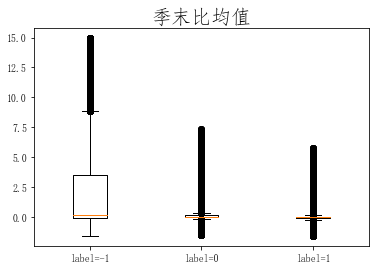

In [197]:
import matplotlib.pyplot as plt

fig = plt.figure()  # 创建画布
ax = plt.subplot()  # 创建作图区域
# 蓝色矩形的红线：50%分位点是4.5,上边沿：25%分位点是2.25,下边沿：75%分位点是6.75
ax.boxplot([label0,label1,label2],labels=labels)
plt.title('季末比均值',fontsize=20)
plt.show()

In [207]:
label = data[data.label == 0].X26.replace([np.inf, -np.inf], np.nan)
label = label[label.notna()]
label = label[(label<np.percentile(label,99)) & (label>np.percentile(label,1))]
label0 = np.log2(label)

label = data[data.label == 1].X26.replace([np.inf, -np.inf], np.nan)
label = label[label.notna()]
label = label[(label<np.percentile(label,99)) & (label>np.percentile(label,1))]
label1 = np.log2(label)

label = data[data.label == 2].X26.replace([np.inf, -np.inf], np.nan)
label = label[label.notna()]
label = label[(label<np.percentile(label,99)) & (label>np.percentile(label,1))]
label2 = np.log2(label)

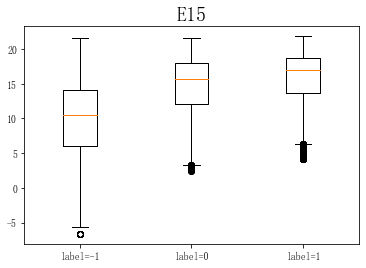

In [208]:
import matplotlib.pyplot as plt
fig = plt.figure()  # 创建画布
ax = plt.subplot()  # 创建作图区域
# 蓝色矩形的红线：50%分位点是4.5,上边沿：25%分位点是2.25,下边沿：75%分位点是6.75
ax.boxplot([label0,label1,label2],labels=labels)
plt.title('E15',fontsize=20)
plt.show()

In [172]:
label = data[data.label == 0].label_fea.replace([np.inf, -np.inf], np.nan)
label = label[label.notna()]
label = label[(label<np.percentile(label,99)) & (label>np.percentile(label,1))]
label0 = np.log2(label)

label = data[data.label == 1].label_fea.replace([np.inf, -np.inf], np.nan)
label = label[label.notna()]
label = label[(label<np.percentile(label,99)) & (label>np.percentile(label,1))]
label1 = np.log2(label)

label = data[data.label == 2].label_fea.replace([np.inf, -np.inf], np.nan)
label = label[label.notna()]
label = label[(label<np.percentile(label,99)) & (label>np.percentile(label,1))]
label2 = np.log2(label)

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


D:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


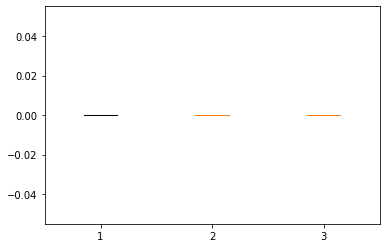

In [173]:
import matplotlib.pyplot as plt
fig = plt.figure()  # 创建画布
ax = plt.subplot()  # 创建作图区域
# 蓝色矩形的红线：50%分位点是4.5,上边沿：25%分位点是2.25,下边沿：75%分位点是6.75
ax.boxplot([label0,label1,label2])
plt.show()

In [209]:
label = data[data.label == 0].X26_sdiff.replace([np.inf, -np.inf], np.nan)
label = label[label.notna()]
label = label[(label<np.percentile(label,99)) & (label>np.percentile(label,1))]
label0 = label

label = data[data.label == 1].X26_sdiff.replace([np.inf, -np.inf], np.nan)
label = label[label.notna()]
label = label[(label<np.percentile(label,99)) & (label>np.percentile(label,1))]
label1 = label

label = data[data.label == 2].X26_sdiff.replace([np.inf, -np.inf], np.nan)
label = label[label.notna()]
label = label[(label<np.percentile(label,99)) & (label>np.percentile(label,1))]
label2 = label

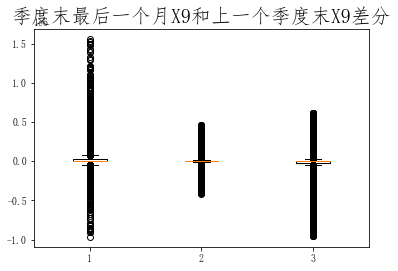

In [210]:
fig = plt.figure()  # 创建画布
ax = plt.subplot()  # 创建作图区域
# 蓝色矩形的红线：50%分位点是4.5,上边沿：25%分位点是2.25,下边沿：75%分位点是6.75
ax.boxplot([label0,label1,label2])
plt.title('季度末最后一个月X9和上一个季度末X9差分',fontsize=20)
plt.show()

In [131]:
min(data[data.label == 0].X9_mean1.values)

0.3333333333333333

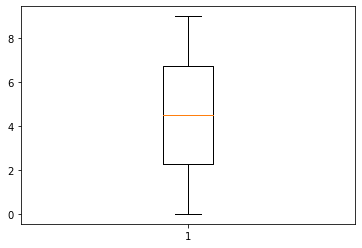

In [130]:
import matplotlib.pyplot as plt
fig = plt.figure()  # 创建画布
ax = plt.subplot()  # 创建作图区域
# 蓝色矩形的红线：50%分位点是4.5,上边沿：25%分位点是2.25,下边沿：75%分位点是6.75
ax.boxplot(range(10))
plt.show()

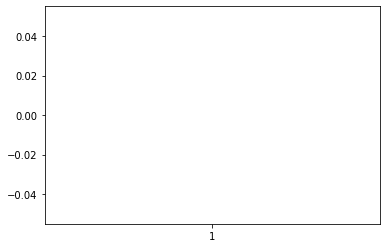

In [124]:
import matplotlib.pyplot as plt
fig = plt.figure()  # 创建画布
ax = plt.subplot()  # 创建作图区域
# 蓝色矩形的红线：50%分位点是4.5,上边沿：25%分位点是2.25,下边沿：75%分位点是6.75
ax.boxplot([data[data.label == 0].X9_mean1, data[data.label == 1].X9_mean1, data[data.label == 2].X9_mean1])
plt.show()

In [109]:
data['X9_mean1']

0          1.644742
1          0.335060
2          0.996813
3         14.622152
4          0.873692
            ...    
222013     0.896016
222014     0.996524
222015     0.977451
222016     0.999963
222017     1.033249
Name: X9_mean1, Length: 222018, dtype: float64